<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/IRC010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 生成模拟数据
X, y = make_classification(
    n_samples=10000, n_features=20, n_classes=2, n_informative=8, n_redundant=2, random_state=42
)
y_multi = np.hstack([y.reshape(-1, 1), (y ^ 1).reshape(-1, 1)])  # 创建两个相关任务

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y_multi, test_size=0.2, random_state=42
)

# 转换Tensor
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# 定义专家网络模块
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.GELU(),
            nn.LayerNorm(output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# 定义CGC层（核心组件）
class CGC(nn.Module):
    def __init__(self, input_dim, expert_dim, num_shared_experts, num_task_experts, num_tasks):
        super().__init__()
        self.num_tasks = num_tasks

        # 共享专家
        self.shared_experts = nn.ModuleList([
            Expert(input_dim, expert_dim) for _ in range(num_shared_experts)
        ])

        # 任务专家
        self.task_experts = nn.ModuleList([
            nn.ModuleList([
                Expert(input_dim, expert_dim) for _ in range(num_task_experts)
            ]) for _ in range(num_tasks)
        ])

        # 门控网络
        self.gates = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, num_shared_experts + num_task_experts),
                nn.Softmax(dim=-1)
            ) for _ in range(num_tasks)
        ])

    def forward(self, x):
        # 生成所有专家输出
        shared_outputs = [expert(x) for expert in self.shared_experts]
        task_outputs = [
            [expert(x) for expert in self.task_experts[i]]
            for i in range(self.num_tasks)
        ]

        # 门控机制
        outputs = []
        for i in range(self.num_tasks):
            # 合并共享和任务专家
            all_experts = shared_outputs + task_outputs[i]
            expert_tensor = torch.stack(all_experts, dim=1)  # [batch, num_experts, dim]

            # 计算门控权重
            gate_weights = self.gates[i](x)  # [batch, num_experts]

            # 加权融合
            weighted_output = torch.einsum('be,bed->bd', gate_weights, expert_tensor)
            outputs.append(weighted_output)

        return outputs

# 定义完整PLE模型
class PLE(nn.Module):
    def __init__(self, input_dim, num_tasks, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList()
        self.num_tasks = num_tasks

        # 构建多个CGC层
        layer_dims = [input_dim] + [64]*(num_layers-1)
        for i in range(num_layers):
            self.layers.append(
                CGC(
                    input_dim=layer_dims[i],
                    expert_dim=64,
                    num_shared_experts=2,
                    num_task_experts=2,
                    num_tasks=num_tasks
                )
            )

        # 任务特定塔网络
        self.towers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1),
                nn.Sigmoid()
            ) for _ in range(num_tasks)
        ])

    def forward(self, x):
        # 修改初始化方式，确保task_outputs与layer_outputs维度匹配
        task_outputs = [torch.zeros(x.shape[0], 64, device=x.device) for _ in range(self.num_tasks)]

        # 逐层处理
        for layer in self.layers:
            layer_outputs = layer(x)
            # 更新每个任务的特征
            for i in range(self.num_tasks):
                task_outputs[i] = task_outputs[i] + layer_outputs[i]  # 维度已匹配，可以相加
                x = torch.stack(task_outputs).mean(dim=0)  # 共享特征更新

        # 最终预测
        outputs = []
        for i in range(self.num_tasks):
            outputs.append(self.towers[i](task_outputs[i]))

        return torch.cat(outputs, dim=1)
# 初始化模型
model = PLE(input_dim=20, num_tasks=2)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练循环
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss1 = criterion(outputs[:, 0], y_train[:, 0])
    loss2 = criterion(outputs[:, 1], y_train[:, 1])
    total_loss = loss1 + loss2

    total_loss.backward()
    optimizer.step()

    # 验证
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        pred1 = (test_outputs[:, 0] > 0.5).float()
        pred2 = (test_outputs[:, 1] > 0.5).float()

        acc1 = accuracy_score(y_test[:, 0].numpy(), pred1.numpy())
        acc2 = accuracy_score(y_test[:, 1].numpy(), pred2.numpy())

    print(f"Epoch {epoch+1:02d} | Loss: {total_loss.item():.4f} | "
          f"Task1 Acc: {acc1:.4f} | Task2 Acc: {acc2:.4f}")

Epoch 01 | Loss: 1.3766 | Task1 Acc: 0.5475 | Task2 Acc: 0.6660
Epoch 02 | Loss: 1.3245 | Task1 Acc: 0.6440 | Task2 Acc: 0.7145
Epoch 03 | Loss: 1.2774 | Task1 Acc: 0.7105 | Task2 Acc: 0.7280
Epoch 04 | Loss: 1.2334 | Task1 Acc: 0.7405 | Task2 Acc: 0.7460
Epoch 05 | Loss: 1.1914 | Task1 Acc: 0.7595 | Task2 Acc: 0.7550
Epoch 06 | Loss: 1.1509 | Task1 Acc: 0.7620 | Task2 Acc: 0.7610
Epoch 07 | Loss: 1.1113 | Task1 Acc: 0.7715 | Task2 Acc: 0.7725
Epoch 08 | Loss: 1.0726 | Task1 Acc: 0.7800 | Task2 Acc: 0.7800
Epoch 09 | Loss: 1.0347 | Task1 Acc: 0.7850 | Task2 Acc: 0.7840
Epoch 10 | Loss: 0.9978 | Task1 Acc: 0.7880 | Task2 Acc: 0.7910
Epoch 11 | Loss: 0.9623 | Task1 Acc: 0.7950 | Task2 Acc: 0.7970
Epoch 12 | Loss: 0.9284 | Task1 Acc: 0.7970 | Task2 Acc: 0.8050
Epoch 13 | Loss: 0.8964 | Task1 Acc: 0.8025 | Task2 Acc: 0.8085
Epoch 14 | Loss: 0.8662 | Task1 Acc: 0.8105 | Task2 Acc: 0.8130
Epoch 15 | Loss: 0.8376 | Task1 Acc: 0.8150 | Task2 Acc: 0.8180
Epoch 16 | Loss: 0.8102 | Task1 Acc: 0.8

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Expert(nn.Module):
    """
    专家网络模块，由一个全连接层、GELU激活函数和LayerNorm组成。
    """
    def __init__(self, input_dim, output_dim):
        super(Expert, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.GELU(),
            nn.LayerNorm(output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class CGC(nn.Module):
    """
    CGC (Customized Gate Control) 层，PLE模型的核心组件。
    包含共享专家、任务专家和门控网络。
    """
    def __init__(self, input_dim, expert_dim, num_shared_experts, num_task_experts, num_tasks):
        super(CGC, self).__init__()
        self.num_tasks = num_tasks

        # 共享专家网络
        self.shared_experts = nn.ModuleList([
            Expert(input_dim, expert_dim) for _ in range(num_shared_experts)
        ])

        # 任务特定专家网络
        self.task_experts = nn.ModuleList([
            nn.ModuleList([
                Expert(input_dim, expert_dim) for _ in range(num_task_experts)
            ]) for _ in range(num_tasks)
        ])

        # 门控网络
        self.gates = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, num_shared_experts + num_task_experts),
                nn.Softmax(dim=-1)
            ) for _ in range(num_tasks)
        ])

    def forward(self, x):
        # 获取所有专家的输出
        shared_outputs = [expert(x) for expert in self.shared_experts]
        task_outputs = [
            [expert(x) for expert in self.task_experts[i]]
            for i in range(self.num_tasks)
        ]

        # 门控机制，对专家输出进行加权融合
        outputs = []
        for i in range(self.num_tasks):
            # 合并共享专家和任务特定专家的输出
            all_experts = shared_outputs + task_outputs[i]
            expert_tensor = torch.stack(all_experts, dim=1)  # [batch, num_experts, dim]

            # 计算门控权重
            gate_weights = self.gates[i](x)  # [batch, num_experts]

            # 加权融合专家输出
            weighted_output = torch.einsum('be,bed->bd', gate_weights, expert_tensor)
            outputs.append(weighted_output)

        return outputs

class PLE(nn.Module):
    """
    PLE (Progressive Layered Extraction) 模型，用于多任务学习。
    由多个 CGC 层和任务特定塔网络组成。
    """
    def __init__(self, input_dim, num_tasks, num_layers=2, expert_dim=64,
                 num_shared_experts=2, num_task_experts=2):
        super(PLE, self).__init__()
        self.num_tasks = num_tasks

        # 构建多个 CGC 层
        self.layers = nn.ModuleList()
        layer_dims = [input_dim] + [expert_dim]*(num_layers-1)
        for i in range(num_layers):
            self.layers.append(
                CGC(
                    input_dim=layer_dims[i],
                    expert_dim=expert_dim,
                    num_shared_experts=num_shared_experts,
                    num_task_experts=num_task_experts,
                    num_tasks=num_tasks
                )
            )

        # 任务特定塔网络
        self.towers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(expert_dim, expert_dim // 2),  # 使用 expert_dim
                nn.ReLU(),
                nn.Linear(expert_dim // 2, 1),  # 使用 expert_dim
                nn.Sigmoid()
            ) for _ in range(num_tasks)
        ])
    def forward(self, x):
        # 初始化任务输出
        task_outputs = [torch.zeros(x.shape[0], self.layers[0].shared_experts[0].fc[0].out_features, device=x.device) for _ in range(self.num_tasks)]
        # 逐层处理
        for layer in self.layers:
            layer_outputs = layer(x)
            # 更新每个任务的特征
            for i in range(self.num_tasks):
                task_outputs[i] = task_outputs[i] + layer_outputs[i]
                x = torch.stack(task_outputs).mean(dim=0)  # 更新共享特征
        # 最终预测
        outputs = []
        for i in range(self.num_tasks):
            outputs.append(self.towers[i](task_outputs[i]))
        return torch.cat(outputs, dim=1)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 生成模拟数据
X, y = make_classification(n_samples=10000, n_features=20, n_classes=2,
                           n_informative=8, n_redundant=2, random_state=42)
y_multi = torch.tensor(np.hstack([y.reshape(-1, 1), (y ^ 1).reshape(-1, 1)]), dtype=torch.float32)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y_multi, test_size=0.2, random_state=42
)

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)


# 初始化模型、损失函数和优化器
model = PLE(input_dim=20, num_tasks=2)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练循环
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss1 = criterion(outputs[:, 0], y_train[:, 0])
    loss2 = criterion(outputs[:, 1], y_train[:, 1])
    total_loss = loss1 + loss2

    total_loss.backward()
    optimizer.step()

    # 验证
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        pred1 = (test_outputs[:, 0] > 0.5).float()
        pred2 = (test_outputs[:, 1] > 0.5).float()

        acc1 = accuracy_score(y_test[:, 0].cpu().numpy(), pred1.cpu().numpy())
        acc2 = accuracy_score(y_test[:, 1].cpu().numpy(), pred2.cpu().numpy())

    print(f"Epoch {epoch+1:02d} | Loss: {total_loss.item():.4f} | "
          f"Task1 Acc: {acc1:.4f} | Task2 Acc: {acc2:.4f}")

Epoch 01 | Loss: 1.4007 | Task1 Acc: 0.5800 | Task2 Acc: 0.5515
Epoch 02 | Loss: 1.3704 | Task1 Acc: 0.6390 | Task2 Acc: 0.5980
Epoch 03 | Loss: 1.3422 | Task1 Acc: 0.6810 | Task2 Acc: 0.6400
Epoch 04 | Loss: 1.3156 | Task1 Acc: 0.7085 | Task2 Acc: 0.6640
Epoch 05 | Loss: 1.2900 | Task1 Acc: 0.7240 | Task2 Acc: 0.6800
Epoch 06 | Loss: 1.2651 | Task1 Acc: 0.7390 | Task2 Acc: 0.7005
Epoch 07 | Loss: 1.2405 | Task1 Acc: 0.7475 | Task2 Acc: 0.7090
Epoch 08 | Loss: 1.2160 | Task1 Acc: 0.7550 | Task2 Acc: 0.7225
Epoch 09 | Loss: 1.1914 | Task1 Acc: 0.7540 | Task2 Acc: 0.7320
Epoch 10 | Loss: 1.1667 | Task1 Acc: 0.7580 | Task2 Acc: 0.7385
Epoch 11 | Loss: 1.1419 | Task1 Acc: 0.7615 | Task2 Acc: 0.7445
Epoch 12 | Loss: 1.1171 | Task1 Acc: 0.7665 | Task2 Acc: 0.7490
Epoch 13 | Loss: 1.0923 | Task1 Acc: 0.7715 | Task2 Acc: 0.7565
Epoch 14 | Loss: 1.0677 | Task1 Acc: 0.7785 | Task2 Acc: 0.7605
Epoch 15 | Loss: 1.0434 | Task1 Acc: 0.7825 | Task2 Acc: 0.7645
Epoch 16 | Loss: 1.0195 | Task1 Acc: 0.7

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Expert(nn.Module):
    """专家网络模块"""
    def __init__(self, input_dim, hidden_units, activation='relu',
                 dropout=0, use_bn=False, init_std=1e-4):
        super().__init__()
        self.layers = nn.ModuleList()
        input_size = input_dim
        for units in hidden_units:
            self.layers.append(nn.Linear(input_size, units))
            if use_bn:
                self.layers.append(nn.BatchNorm1d(units))
            if activation == 'relu':
                self.layers.append(nn.ReLU())
            elif activation == 'gelu':
                self.layers.append(nn.GELU())
            if dropout > 0:
                self.layers.append(nn.Dropout(dropout))
            input_size = units  # Update input_size for the next layer

        # 参数初始化
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, std=init_std)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class CGCLayer(nn.Module):
    """自定义门控组合层"""
    def __init__(self, input_dim, num_tasks, shared_expert_num, specific_expert_num,
                 expert_hidden_units, gate_hidden_units, activation='relu', dropout=0,
                 use_bn=False, init_std=1e-4):
        super().__init__()
        self.num_tasks = num_tasks
        self.shared_expert_num = shared_expert_num
        self.specific_expert_num = specific_expert_num
        self.expert_hidden_units = expert_hidden_units # Store expert_hidden_units

        # 任务特定专家
        self.task_experts = nn.ModuleList([
            nn.ModuleList([
                Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
                for _ in range(specific_expert_num)
            ]) for _ in range(num_tasks)
        ])

        # 共享专家
        self.shared_experts = nn.ModuleList([
            Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
            for _ in range(shared_expert_num)
        ])

        # 门控网络 - adjust input dim based on expert hidden units
        gate_input_dim = expert_hidden_units[-1] if expert_hidden_units else input_dim  # 输入维度需要与专家网络输出一致
        self.gates = nn.ModuleList([
            nn.Sequential(
                Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),
                nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                          specific_expert_num + shared_expert_num),
                nn.Softmax(dim=-1)
            ) for _ in range(num_tasks)
        ])

        # 共享门控网络 - adjust input dim based on expert hidden units
        self.shared_gate = nn.Sequential(
            Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),
            nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                      num_tasks * specific_expert_num + shared_expert_num),
            nn.Softmax(dim=-1)
        )

    def forward(self, task_inputs, shared_input):
        # 任务特定专家输出
        task_expert_outputs = []
        for i in range(self.num_tasks):
            task_experts = [expert(task_inputs[i]) for expert in self.task_experts[i]]  # 使用task_inputs[i]而不是shared_input
            task_expert_outputs.extend(task_experts)

        # 共享专家输出
        shared_expert_outputs = [expert(shared_input) for expert in self.shared_experts]

        # 任务门控
        task_outputs = []
        for i in range(self.num_tasks):
            # 组合专家输出
            experts = task_expert_outputs[i*self.specific_expert_num:(i+1)*self.specific_expert_num]
            experts += shared_expert_outputs
            expert_tensor = torch.stack(experts, dim=1)  # [B, num_experts, dim]

            # 计算门控权重
            gate_weights = self.gates[i](task_inputs[i])  # [B, num_experts]  输入更改为task_inputs[i]

            # 加权融合
            weighted_output = torch.einsum('be,bed->bd', gate_weights, expert_tensor)
            task_outputs.append(weighted_output)

        # 共享门控
        all_experts = task_expert_outputs + shared_expert_outputs
        expert_tensor = torch.stack(all_experts, dim=1)  # [B, total_experts, dim]

        # 计算共享门控权重
        shared_gate_weights = self.shared_gate(shared_input)

        # 共享输出
        shared_output = torch.einsum('be,bed->bd', shared_gate_weights, expert_tensor)

        return task_outputs, shared_output

class PLE(nn.Module):
    """渐进式分层抽取网络"""
    def __init__(self, input_dim, num_tasks, num_levels=2,
                 shared_expert_num=1, specific_expert_num=1,
                 expert_hidden_units=(256,), tower_hidden_units=(64,),
                 gate_hidden_units=(), activation='relu', dropout=0,
                 use_bn=False, task_types=('binary', 'binary'), init_std=1e-4):
        super().__init__()
        self.num_tasks = num_tasks
        self.num_levels = num_levels

        # 构建多层CGC
        self.cgc_layers = nn.ModuleList()
        for level in range(num_levels):
            self.cgc_layers.append(
                CGCLayer(
                    input_dim=input_dim if level == 0 else expert_hidden_units[-1] , # 第一层输入是input_dim，后续是expert_hidden_units的输出
                    num_tasks=num_tasks,
                    shared_expert_num=shared_expert_num,
                    specific_expert_num=specific_expert_num,
                    expert_hidden_units=expert_hidden_units,
                    gate_hidden_units=gate_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                )
            )


        # 任务特定塔网络
        self.towers = nn.ModuleList()
        for i in range(num_tasks):
            tower = nn.Sequential(
                Expert(
                    input_dim=expert_hidden_units[-1], # 输入维度和expert的输出维度一致
                    hidden_units=tower_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                ),
                nn.Linear(tower_hidden_units[-1] if tower_hidden_units else expert_hidden_units[-1], 1) #  线性层输入
            )
            self.towers.append(tower)

        # 输出激活函数
        self.task_activations = nn.ModuleList([
            nn.Sigmoid() if task_type == 'binary' else nn.Identity()
            for task_type in task_types
        ])

    def forward(self, x):
        # 初始化输入：每个任务和共享输入相同
        task_inputs = [x.clone() for _ in range(self.num_tasks)]
        shared_input = x.clone()

        # 逐层处理
        for cgc_layer in self.cgc_layers:
            task_inputs, shared_input = cgc_layer(task_inputs, shared_input)
            # 添加残差连接  这里残差连接不应该直接加，而是只针对task_inputs
            for i in range(self.num_tasks):
                task_inputs[i] = task_inputs[i]  # + shared_input

        # 最终预测
        outputs = []
        for i in range(self.num_tasks):
            logit = self.towers[i](task_inputs[i])
            output = self.task_activations[i](logit)
            outputs.append(output)

        return torch.cat(outputs, dim=1)

# 使用示例
if __name__ == "__main__":
    # 模拟数据
    batch_size = 32
    input_dim = 20
    num_tasks = 2

    # 初始化模型
    model = PLE(
        input_dim=input_dim,
        num_tasks=num_tasks,
        num_levels=2,
        shared_expert_num=2,
        specific_expert_num=1,
        expert_hidden_units=(256, 128),
        tower_hidden_units=(64,),
        gate_hidden_units=(128,),
        dropout=0.2,
        use_bn=True,
        task_types=('binary', 'binary')
    )

    # 测试前向传播
    x = torch.randn(batch_size, input_dim)
    outputs = model(x)
    print(f"Output shape: {outputs.shape}")  # [32, 2]

    # 训练设置
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 模拟训练步骤
    y_true = torch.randint(0, 2, (batch_size, num_tasks)).float()
    preds = model(x)
    loss = sum([criterion(preds[:, i], y_true[:, i]) for i in range(num_tasks)])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Training loss: {loss.item():.4f}")


Output shape: torch.Size([32, 2])
Training loss: 1.3709


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd  # 导入 pandas


class Expert(nn.Module):
    """专家网络模块"""

    def __init__(self, input_dim, hidden_units, activation='relu',
                 dropout=0, use_bn=False, init_std=1e-4):
        super().__init__()
        self.layers = nn.ModuleList()
        input_size = input_dim
        for units in hidden_units:
            self.layers.append(nn.Linear(input_size, units))
            if use_bn:
                self.layers.append(nn.BatchNorm1d(units))
            if activation == 'relu':
                self.layers.append(nn.ReLU())
            elif activation == 'gelu':
                self.layers.append(nn.GELU())
            if dropout > 0:
                self.layers.append(nn.Dropout(dropout))
            input_size = units  # Update input_size for the next layer

        # 参数初始化
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, std=init_std)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class CGCLayer(nn.Module):
    """自定义门控组合层"""

    def __init__(self, input_dim, num_tasks, shared_expert_num, specific_expert_num,
                 expert_hidden_units, gate_hidden_units, activation='relu', dropout=0,
                 use_bn=False, init_std=1e-4):
        super().__init__()
        self.num_tasks = num_tasks
        self.shared_expert_num = shared_expert_num
        self.specific_expert_num = specific_expert_num
        self.expert_hidden_units = expert_hidden_units  # Store expert_hidden_units

        # 任务特定专家
        self.task_experts = nn.ModuleList([
            nn.ModuleList([
                Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
                for _ in range(specific_expert_num)
            ]) for _ in range(num_tasks)
        ])

        # 共享专家
        self.shared_experts = nn.ModuleList([
            Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
            for _ in range(shared_expert_num)
        ])

        # 门控网络 - adjust input dim based on expert hidden units
        gate_input_dim = expert_hidden_units[-1] if expert_hidden_units else input_dim  # 输入维度需要与专家网络输出一致
        self.gates = nn.ModuleList([
            nn.Sequential(
                Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),
                nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                          specific_expert_num + shared_expert_num),
                nn.Softmax(dim=-1)
            ) for _ in range(num_tasks)
        ])

        # 共享门控网络 - adjust input dim based on expert hidden units
        self.shared_gate = nn.Sequential(
            Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),
            nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                      num_tasks * specific_expert_num + shared_expert_num),
            nn.Softmax(dim=-1)
        )

    def forward(self, task_inputs, shared_input):
        # 任务特定专家输出
        task_expert_outputs = []
        for i in range(self.num_tasks):
            task_experts = [expert(task_inputs[i]) for expert in self.task_experts[i]]  # 使用task_inputs[i]而不是shared_input
            task_expert_outputs.extend(task_experts)

        # 共享专家输出
        shared_expert_outputs = [expert(shared_input) for expert in self.shared_experts]

        # 任务门控
        task_outputs = []
        for i in range(self.num_tasks):
            # 组合专家输出
            experts = task_expert_outputs[i * self.specific_expert_num:(i + 1) * self.specific_expert_num]
            experts += shared_expert_outputs
            expert_tensor = torch.stack(experts, dim=1)  # [B, num_experts, dim]

            # 计算门控权重
            gate_weights = self.gates[i](task_inputs[i])  # [B, num_experts]  输入更改为task_inputs[i]

            # 加权融合
            weighted_output = torch.einsum('be,bed->bd', gate_weights, expert_tensor)
            task_outputs.append(weighted_output)

        # 共享门控
        all_experts = task_expert_outputs + shared_expert_outputs
        expert_tensor = torch.stack(all_experts, dim=1)  # [B, total_experts, dim]

        # 计算共享门控权重
        shared_gate_weights = self.shared_gate(shared_input)

        # 共享输出
        shared_output = torch.einsum('be,bed->bd', shared_gate_weights, expert_tensor)

        return task_outputs, shared_output


class PLE(nn.Module):
    """渐进式分层抽取网络"""

    def __init__(self, input_dim, num_tasks, num_levels=2,
                 shared_expert_num=1, specific_expert_num=1,
                 expert_hidden_units=(256,), tower_hidden_units=(64,),
                 gate_hidden_units=(), activation='relu', dropout=0,
                 use_bn=False, task_types=('binary', 'binary'), init_std=1e-4):
        super().__init__()
        self.num_tasks = num_tasks
        self.num_levels = num_levels

        # 构建多层CGC
        self.cgc_layers = nn.ModuleList()
        for level in range(num_levels):
            self.cgc_layers.append(
                CGCLayer(
                    input_dim=input_dim if level == 0 else expert_hidden_units[-1],
                    # 第一层输入是input_dim，后续是expert_hidden_units的输出
                    num_tasks=num_tasks,
                    shared_expert_num=shared_expert_num,
                    specific_expert_num=specific_expert_num,
                    expert_hidden_units=expert_hidden_units,
                    gate_hidden_units=gate_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                )
            )

        # 任务特定塔网络
        self.towers = nn.ModuleList()
        for i in range(num_tasks):
            tower = nn.Sequential(
                Expert(
                    input_dim=expert_hidden_units[-1],  # 输入维度和expert的输出维度一致
                    hidden_units=tower_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                ),
                nn.Linear(tower_hidden_units[-1] if tower_hidden_units else expert_hidden_units[-1], 1)  # 线性层输入
            )
            self.towers.append(tower)

        # 输出激活函数
        self.task_activations = nn.ModuleList([
            nn.Sigmoid() if task_type == 'binary' else nn.Identity()
            for task_type in task_types
        ])

    def forward(self, x):
        # 初始化输入：每个任务和共享输入相同
        task_inputs = [x.clone() for _ in range(self.num_tasks)]
        shared_input = x.clone()

        # 逐层处理
        for cgc_layer in self.cgc_layers:
            task_inputs, shared_input = cgc_layer(task_inputs, shared_input)
            # 添加残差连接  这里残差连接不应该直接加，而是只针对task_inputs
            for i in range(self.num_tasks):
                task_inputs[i] = task_inputs[i]  # + shared_input

        # 最终预测
        outputs = []
        for i in range(self.num_tasks):
            logit = self.towers[i](task_inputs[i])
            output = self.task_activations[i](logit)
            outputs.append(output)

        return torch.cat(outputs, dim=1)


# 使用示例
if __name__ == "__main__":
    # 模拟数据
    batch_size = 32
    # 模拟的输入特征，包括连续特征和离散特征
    # 连续特征: 'age', 'income'
    # 离散特征: 'gender', 'city'

    # 生成模拟数据
    np.random.seed(42)
    data = {
        'age': np.random.randint(18, 65, batch_size),  # 连续
        'income': np.random.normal(50000, 20000, batch_size),  # 连续
        'gender': np.random.choice(['Male', 'Female'], batch_size),  # 离散
        'city': np.random.choice(['New York', 'London', 'Paris'], batch_size)  # 离散
    }

    # 数据预处理
    # 1. 连续特征: 标准化
    # 2. 离散特征: One-Hot 编码

    # 将数据转换为 Pandas DataFrame
    df = pd.DataFrame(data)

    # 定义预处理流程
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['age', 'income']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['gender', 'city'])
        ],
        remainder='passthrough'  # 保持未指定的列
    )

    # 拟合和转换数据
    processed_data = preprocessor.fit_transform(df)  # 使用 DataFrame

    # 计算输入维度，one-hot后的维度
    input_dim = processed_data.shape[1]

    # 将数据转换为PyTorch张量
    x = torch.tensor(processed_data, dtype=torch.float32)

    num_tasks = 2

    # 初始化模型
    model = PLE(
        input_dim=input_dim,
        num_tasks=num_tasks,
        num_levels=2,
        shared_expert_num=2,
        specific_expert_num=1,
        expert_hidden_units=(256, 128),
        tower_hidden_units=(64,),
        gate_hidden_units=(128,),
        dropout=0.2,
        use_bn=True,
        task_types=('binary', 'binary')
    )

    # 测试前向传播
    outputs = model(x)
    print(f"Output shape: {outputs.shape}")  # [32, 2]

    # 训练设置
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 模拟训练步骤
    y_true = torch.randint(0, 2, (batch_size, num_tasks)).float()
    preds = model(x)
    loss = sum([criterion(preds[:, i], y_true[:, i]) for i in range(num_tasks)])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Training loss: {loss.item():.4f}")


Output shape: torch.Size([32, 2])
Training loss: 1.3736


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets  # 导入 datasets
import numpy as np
import os  # 导入 os

# 1. 定义 PLE 模型 (保持不变)
class Expert(nn.Module):
    """专家网络模块"""

    def __init__(self, input_dim, hidden_units, activation='relu',
                 dropout=0, use_bn=False, init_std=1e-4):
        super().__init__()
        self.layers = nn.ModuleList()
        input_size = input_dim
        for units in hidden_units:
            self.layers.append(nn.Linear(input_size, units))
            if use_bn:
                self.layers.append(nn.BatchNorm1d(units))
            if activation == 'relu':
                self.layers.append(nn.ReLU())
            elif activation == 'gelu':
                self.layers.append(nn.GELU())
            if dropout > 0:
                self.layers.append(nn.Dropout(dropout))
            input_size = units  # Update input_size for the next layer

        # 参数初始化
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, std=init_std)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class CGCLayer(nn.Module):
    """自定义门控组合层"""

    def __init__(self, input_dim, num_tasks, shared_expert_num, specific_expert_num,
                 expert_hidden_units, gate_hidden_units, activation='relu', dropout=0,
                 use_bn=False, init_std=1e-4):
        super().__init__()
        self.num_tasks = num_tasks
        self.shared_expert_num = shared_expert_num
        self.specific_expert_num = specific_expert_num
        self.expert_hidden_units = expert_hidden_units  # Store expert_hidden_units

        # 任务特定专家
        self.task_experts = nn.ModuleList([
            nn.ModuleList([
                Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
                for _ in range(specific_expert_num)
            ]) for _ in range(num_tasks)
        ])

        # 共享专家
        self.shared_experts = nn.ModuleList([
            Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
            for _ in range(shared_expert_num)
        ])

        # 门控网络 - adjust input dim based on expert hidden units
        gate_input_dim = expert_hidden_units[-1] if expert_hidden_units else input_dim  # 输入维度需要与专家网络输出一致
        self.gates = nn.ModuleList([
            nn.Sequential(
                Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),
                nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                          specific_expert_num + shared_expert_num),
                nn.Softmax(dim=-1)
            ) for _ in range(num_tasks)
        ])

        # 共享门控网络 - adjust input dim based on expert hidden units
        self.shared_gate = nn.Sequential(
            Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),
            nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                      num_tasks * specific_expert_num + shared_expert_num),
            nn.Softmax(dim=-1)
        )

    def forward(self, task_inputs, shared_input):
        # 任务特定专家输出
        task_expert_outputs = []
        for i in range(self.num_tasks):
            task_experts = [expert(task_inputs[i]) for expert in self.task_experts[i]]  # 使用task_inputs[i]而不是shared_input
            task_expert_outputs.extend(task_experts)

        # 共享专家输出
        shared_expert_outputs = [expert(shared_input) for expert in self.shared_experts]

        # 任务门控
        task_outputs = []
        for i in range(self.num_tasks):
            # 组合专家输出
            experts = task_expert_outputs[i * self.specific_expert_num:(i + 1) * self.specific_expert_num]
            experts += shared_expert_outputs
            expert_tensor = torch.stack(experts, dim=1)  # [B, num_experts, dim]

            # 计算门控权重
            gate_weights = self.gates[i](task_inputs[i])  # [B, num_experts]  输入更改为task_inputs[i]

            # 加权融合
            weighted_output = torch.einsum('be,bed->bd', gate_weights, expert_tensor)
            task_outputs.append(weighted_output)

        # 共享门控
        all_experts = task_expert_outputs + shared_expert_outputs
        expert_tensor = torch.stack(all_experts, dim=1)  # [B, total_experts, dim]

        # 计算共享门控权重
        shared_gate_weights = self.shared_gate(shared_input)

        # 共享输出
        shared_output = torch.einsum('be,bed->bd', shared_gate_weights, expert_tensor)

        return task_outputs, shared_output


class PLE(nn.Module):
    """渐进式分层抽取网络"""

    def __init__(self, input_dim, num_tasks, num_levels=2,
                 shared_expert_num=1, specific_expert_num=1,
                 expert_hidden_units=(256,), tower_hidden_units=(64,),
                 gate_hidden_units=(), activation='relu', dropout=0,
                 use_bn=False, task_types=('binary', 'binary'), init_std=1e-4):
        super().__init__()
        self.num_tasks = num_tasks
        self.num_levels = num_levels

        # 构建多层CGC
        self.cgc_layers = nn.ModuleList()
        for level in range(num_levels):
            self.cgc_layers.append(
                CGCLayer(
                    input_dim=input_dim if level == 0 else expert_hidden_units[-1],
                    # 第一层输入是input_dim，后续是expert_hidden_units的输出
                    num_tasks=num_tasks,
                    shared_expert_num=shared_expert_num,
                    specific_expert_num=specific_expert_num,
                    expert_hidden_units=expert_hidden_units,
                    gate_hidden_units=gate_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                )
            )

        # 任务特定塔网络
        self.towers = nn.ModuleList()
        for i in range(num_tasks):
            tower = nn.Sequential(
                Expert(
                    input_dim=expert_hidden_units[-1],  # 输入维度和expert的输出维度一致
                    hidden_units=tower_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                ),
                nn.Linear(tower_hidden_units[-1] if tower_hidden_units else expert_hidden_units[-1], 1)  # 线性层输入
            )
            self.towers.append(tower)

        # 输出激活函数
        self.task_activations = nn.ModuleList([
            nn.Sigmoid() if task_type == 'binary' else nn.Identity()
            for task_type in task_types
        ])

    def forward(self, x):
        # 初始化输入：每个任务和共享输入相同
        task_inputs = [x.clone() for _ in range(self.num_tasks)]
        shared_input = x.clone()

        # 逐层处理
        for cgc_layer in self.cgc_layers:
            task_inputs, shared_input = cgc_layer(task_inputs, shared_input)
            # 添加残差连接  这里残差连接不应该直接加，而是只针对task_inputs
            for i in range(self.num_tasks):
                task_inputs[i] = task_inputs[i]  # + shared_input

        # 最终预测
        outputs = []
        for i in range(self.num_tasks):
            logit = self.towers[i](task_inputs[i])
            output = self.task_activations[i](logit)
            outputs.append(output)

        return torch.cat(outputs, dim=1)


# 2. CIFAR-10 数据集加载和预处理
def load_cifar10(batch_size, img_size=32):
    # 数据预处理
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),  # 如果需要，可以调整大小
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # 加载训练集
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # 加载测试集
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader


## 3. 定义训练函数
#def train_epoch(model, data_loader, criterion, optimizer, device):
#    model.train()
#    running_loss = 0.0
#    for batch_idx, (images, labels) in enumerate(data_loader):
#        images = images.to(device)
#        # 将标签转换为 one-hot 编码，然后转换为 float32
#        labels_onehot = F.one_hot(labels, num_classes=10).float().to(device)
#        optimizer.zero_grad()
#        outputs = model(images)
#        loss = criterion(outputs, labels_onehot)  #  计算 loss
#        loss.backward()
#        optimizer.step()
#        running_loss += loss.item()
#
#    epoch_loss = running_loss / len(data_loader)
#    return epoch_loss
#
#

# 3. 定义训练函数
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        # 将标签转换为 one-hot 编码，然后转换为 float32
        labels_onehot = F.one_hot(labels, num_classes=10).float().to(device)
        optimizer.zero_grad()

        # Reshape images to match the input dimension of the model
        images = images.view(images.size(0), -1) # Flatten the images correctly

        outputs = model(images)
        loss = criterion(outputs, labels_onehot)  #  计算 loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(data_loader)
    return epoch_loss

def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            # 将标签转换为 one-hot 编码，然后转换为 float32
            labels_onehot = F.one_hot(labels, num_classes=10).float().to(device)
            # Reshape images for evaluation
            images = images.view(images.size(0), -1)
            outputs = model(images)
            loss = criterion(outputs, labels_onehot)
            running_loss += loss.item()

            # 计算 accuracy (针对二元分类，多个任务)
            predictions = (outputs > 0.5).float()  # 二分类阈值为0.5
            # 对每个任务，如果预测正确，就加1；然后对所有任务求和，就是总的正确预测数
            correct_predictions += (predictions == labels_onehot).sum().item()
            total_samples += labels.numel()  # 总样本数 (包括所有任务)

    epoch_loss = running_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return epoch_loss, accuracy


# 4. 主函数
if __name__ == "__main__":
    #  设置超参数
    img_size = 32  # 图像大小
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 20  # 训练轮数
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # CIFAR-10 相关设置
    num_classes = 10  # CIFAR-10 的类别数量
    num_tasks = num_classes  # 每个类别作为一个任务

    # 加载数据集
    train_loader, test_loader = load_cifar10(batch_size, img_size)

    # 初始化模型
    input_dim = 3 * img_size * img_size  #  根据图像大小计算输入维度
    model = PLE(
        input_dim=input_dim,
        num_tasks=num_tasks,
        num_levels=2,
        shared_expert_num=1,
        specific_expert_num=1,
        expert_hidden_units=(256, 128),
        tower_hidden_units=(64,),
        gate_hidden_units=(128,),
        dropout=0.2,
        use_bn=True,
        task_types=['binary'] * num_tasks,  #  每个任务都是二分类
    ).to(device)

    # 定义损失函数和优化器
    criterion = nn.BCELoss()  # 二元交叉熵损失
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 训练循环
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = evaluate(model, test_loader, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    print("Training finished!")


Using device: cpu
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified
Epoch 1/20, Train Loss: 0.2960, Val Loss: 0.2426, Val Accuracy: 9.0695
Epoch 2/20, Train Loss: 0.2393, Val Loss: 0.2268, Val Accuracy: 9.1304
Epoch 3/20, Train Loss: 0.2259, Val Loss: 0.2196, Val Accuracy: 9.1651
Epoch 4/20, Train Loss: 0.2154, Val Loss: 0.2138, Val Accuracy: 9.1757
Epoch 5/20, Train Loss: 0.2061, Val Loss: 0.2099, Val Accuracy: 9.1945
Epoch 6/20, Train Loss: 0.1985, Val Loss: 0.2076, Val Accuracy: 9.1949
Epoch 7/20, Train Loss: 0.1919, Val Loss: 0.2061, Val Accuracy: 9.2029
Epoch 8/20, Train Loss: 0.1846, Val Loss: 0.2044, Val Accuracy: 9.2099
Epoch 9/20, Train Loss: 0.1789, Val Loss: 0.2038, Val Accuracy: 9.2126
Epoch 10/20, Train Loss: 0.1728, Val Loss: 0.2043, Val Accuracy: 9.2160
Epoch 11/20, Train Loss: 0.1673, Val Loss: 0.2028, Val Accuracy: 9.2205
Epoch 12/20, Train Loss: 0.1601, Val Loss: 0.2047, Val Accuracy: 9.2122
Epoch 13/20, Train Loss: 0.1548, Val Loss: 0.2049, Val Accuracy: 9.2146
Epoch 14/20, Train Loss: 0.1489, Va

Using device: cpu
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified
Epoch 1/20, Train Loss: 0.2937, Val Loss: 0.2386, Val Accuracy: 0.9084
  Precision: 0.6045, Recall: 0.2421, F1-score: 0.3457
  Per-Class Accuracy: [0.9144 0.9164 0.9    0.9    0.9038 0.9064 0.9029 0.917  0.9098 0.913 ]
  Per-Class Precision: [0.61320755 0.62893082 0.         0.         0.75       0.66
 0.82222222 0.63449367 0.54320988 0.6006192 ]
  Per-Class Recall: [0.39  0.4   0.    0.    0.057 0.132 0.037 0.401 0.616 0.388]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/20, Train Loss: 0.2387, Val Loss: 0.2247, Val Accuracy: 0.9132
  Precision: 0.6583, Recall: 0.2741, F1-score: 0.3870
  Per-Class Accuracy: [0.9216 0.9239 0.9006 0.9002 0.9038 0.9066 0.9129 0.9223 0.9247 0.9152]
  Per-Class Precision: [0.70769231 0.72336449 0.71428571 1.         0.55367232 0.67934783
 0.67385445 0.67286822 0.64018161 0.61550152]
  Per-Class Recall: [0.368 0.387 0.01  0.002 0.196 0.125 0.25  0.434 0.564 0.405]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/20, Train Loss: 0.2244, Val Loss: 0.2167, Val Accuracy: 0.9168
  Precision: 0.6813, Recall: 0.3159, F1-score: 0.4316
  Per-Class Accuracy: [0.9232 0.9304 0.901  0.9    0.9063 0.907  0.9174 0.9303 0.93   0.9225]
  Per-Class Precision: [0.74786325 0.70879121 0.53205128 0.         0.59347181 0.64705882
 0.62428571 0.75207987 0.7293578  0.64900662]
  Per-Class Recall: [0.35  0.516 0.083 0.    0.2   0.154 0.437 0.452 0.477 0.49 ]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/20, Train Loss: 0.2144, Val Loss: 0.2119, Val Accuracy: 0.9182
  Precision: 0.6869, Recall: 0.3350, F1-score: 0.4504
  Per-Class Accuracy: [0.9251 0.9302 0.9076 0.9    0.9095 0.908  0.9202 0.9312 0.9279 0.9226]
  Per-Class Precision: [0.76759062 0.70460705 0.6496063  0.         0.63848397 0.67699115
 0.65490798 0.7826087  0.6488794  0.66005666]
  Per-Class Recall: [0.36  0.52  0.165 0.    0.219 0.153 0.427 0.432 0.608 0.466]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/20, Train Loss: 0.2053, Val Loss: 0.2085, Val Accuracy: 0.9198
  Precision: 0.7036, Recall: 0.3425, F1-score: 0.4607
  Per-Class Accuracy: [0.9266 0.9363 0.9058 0.9    0.9104 0.9068 0.9209 0.9312 0.9329 0.9273]
  Per-Class Precision: [0.68219178 0.74297189 0.67682927 0.         0.62807882 0.63385827
 0.67863248 0.79770992 0.693302   0.72487644]
  Per-Class Recall: [0.498 0.555 0.111 0.    0.255 0.161 0.397 0.418 0.59  0.44 ]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/20, Train Loss: 0.1979, Val Loss: 0.2062, Val Accuracy: 0.9201
  Precision: 0.6876, Recall: 0.3689, F1-score: 0.4802
  Per-Class Accuracy: [0.9286 0.9351 0.9077 0.9    0.9095 0.9087 0.9212 0.9323 0.9371 0.9211]
  Per-Class Precision: [0.72204969 0.72187105 0.64312268 0.         0.60303688 0.62608696
 0.70229008 0.76175041 0.74248366 0.61116965]
  Per-Class Recall: [0.465 0.571 0.173 0.    0.278 0.216 0.368 0.47  0.568 0.58 ]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/20, Train Loss: 0.1907, Val Loss: 0.2052, Val Accuracy: 0.9207
  Precision: 0.6935, Recall: 0.3715, F1-score: 0.4838
  Per-Class Accuracy: [0.9294 0.9338 0.9065 0.9001 0.9116 0.9078 0.9217 0.9355 0.9358 0.9251]
  Per-Class Precision: [0.69090909 0.72899729 0.5826972  0.54545455 0.64646465 0.60714286
 0.6969147  0.78955954 0.71670702 0.68057554]
  Per-Class Recall: [0.532 0.538 0.229 0.006 0.256 0.221 0.384 0.484 0.592 0.473]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/20, Train Loss: 0.1848, Val Loss: 0.2024, Val Accuracy: 0.9213
  Precision: 0.6790, Recall: 0.4031, F1-score: 0.5059
  Per-Class Accuracy: [0.9283 0.9348 0.909  0.8991 0.9104 0.9053 0.926  0.9345 0.9391 0.926 ]
  Per-Class Precision: [0.75774135 0.70913462 0.63157895 0.47867299 0.60743802 0.54337152
 0.7233677  0.75405007 0.76312248 0.64380531]
  Per-Class Recall: [0.416 0.59  0.216 0.101 0.294 0.332 0.421 0.512 0.567 0.582]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/20, Train Loss: 0.1773, Val Loss: 0.2032, Val Accuracy: 0.9213
  Precision: 0.6738, Recall: 0.4123, F1-score: 0.5116
  Per-Class Accuracy: [0.932  0.9331 0.902  0.9006 0.9082 0.9098 0.925  0.9358 0.9419 0.9243]
  Per-Class Precision: [0.68648019 0.73342736 0.51644737 0.51485149 0.57142857 0.60745614
 0.74900398 0.79440789 0.79300699 0.63697858]
  Per-Class Recall: [0.589 0.52  0.314 0.104 0.328 0.277 0.376 0.483 0.567 0.565]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/20, Train Loss: 0.1713, Val Loss: 0.2013, Val Accuracy: 0.9224
  Precision: 0.6779, Recall: 0.4268, F1-score: 0.5238
  Per-Class Accuracy: [0.9305 0.9362 0.9044 0.901  0.912  0.9057 0.9286 0.9356 0.9404 0.9296]
  Per-Class Precision: [0.71448664 0.70382883 0.54330709 0.56097561 0.61811024 0.54742097
 0.7008427  0.75574713 0.74220624 0.6957672 ]
  Per-Class Recall: [0.508 0.625 0.276 0.046 0.314 0.329 0.499 0.526 0.619 0.526]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/20, Train Loss: 0.1650, Val Loss: 0.2054, Val Accuracy: 0.9209
  Precision: 0.6511, Recall: 0.4496, F1-score: 0.5319
  Per-Class Accuracy: [0.9299 0.9343 0.9082 0.8984 0.9101 0.9099 0.9268 0.9326 0.9355 0.923 ]
  Per-Class Precision: [0.68525403 0.68866887 0.59111111 0.46491228 0.57593985 0.59724951
 0.69533528 0.70223325 0.69189189 0.625     ]
  Per-Class Recall: [0.553 0.626 0.266 0.106 0.383 0.304 0.477 0.566 0.64  0.575]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/20, Train Loss: 0.1592, Val Loss: 0.2027, Val Accuracy: 0.9213
  Precision: 0.6550, Recall: 0.4499, F1-score: 0.5334
  Per-Class Accuracy: [0.9276 0.9406 0.9033 0.895  0.9074 0.9083 0.9264 0.9343 0.9387 0.9313]
  Per-Class Precision: [0.73389831 0.74340528 0.52754591 0.44158879 0.54920213 0.5967366
 0.69469027 0.71847134 0.70304302 0.69062119]
  Per-Class Recall: [0.433 0.62  0.316 0.189 0.413 0.256 0.471 0.564 0.67  0.567]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/20, Train Loss: 0.1534, Val Loss: 0.2043, Val Accuracy: 0.9212
  Precision: 0.6511, Recall: 0.4562, F1-score: 0.5365
  Per-Class Accuracy: [0.9311 0.9366 0.9075 0.8963 0.9086 0.9079 0.9264 0.9344 0.9411 0.9218]
  Per-Class Precision: [0.69559748 0.71428571 0.56521739 0.44410876 0.57026144 0.56661046
 0.67934783 0.74501425 0.74969623 0.61054767]
  Per-Class Recall: [0.553 0.61  0.325 0.147 0.349 0.336 0.5   0.523 0.617 0.602]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14/20, Train Loss: 0.1469, Val Loss: 0.2078, Val Accuracy: 0.9207
  Precision: 0.6376, Recall: 0.4804, F1-score: 0.5480
  Per-Class Accuracy: [0.9282 0.9369 0.8948 0.8995 0.909  0.9088 0.9281 0.9341 0.9405 0.9275]
  Per-Class Precision: [0.64387755 0.74765101 0.4679803  0.49376559 0.58007117 0.56811146
 0.65456546 0.72463768 0.73037543 0.66349584]
  Per-Class Recall: [0.631 0.557 0.38  0.198 0.326 0.367 0.595 0.55  0.642 0.558]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15/20, Train Loss: 0.1422, Val Loss: 0.2112, Val Accuracy: 0.9200
  Precision: 0.6261, Recall: 0.4960, F1-score: 0.5535
  Per-Class Accuracy: [0.9334 0.9413 0.8951 0.8902 0.905  0.9112 0.9275 0.9314 0.9397 0.925 ]
  Per-Class Precision: [0.71410256 0.74095683 0.47180667 0.4095941  0.53004808 0.59491525
 0.68861454 0.67963387 0.72789897 0.62781186]
  Per-Class Recall: [0.557 0.635 0.41  0.222 0.441 0.351 0.502 0.594 0.634 0.614]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16/20, Train Loss: 0.1357, Val Loss: 0.2108, Val Accuracy: 0.9205
  Precision: 0.6370, Recall: 0.4770, F1-score: 0.5455
  Per-Class Accuracy: [0.9282 0.9388 0.8955 0.8902 0.9108 0.9084 0.93   0.9353 0.9406 0.9274]
  Per-Class Precision: [0.68217054 0.73373494 0.47343566 0.41993464 0.5787172  0.56666667
 0.71306818 0.7331572  0.77066667 0.65256125]
  Per-Class Recall: [0.528 0.609 0.401 0.257 0.397 0.357 0.502 0.555 0.578 0.586]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17/20, Train Loss: 0.1315, Val Loss: 0.2134, Val Accuracy: 0.9209
  Precision: 0.6341, Recall: 0.4935, F1-score: 0.5550
  Per-Class Accuracy: [0.9296 0.9383 0.9083 0.8941 0.8995 0.9057 0.9293 0.9375 0.9397 0.9267]
  Per-Class Precision: [0.67788462 0.69803516 0.57319224 0.4389234  0.49763033 0.55080214
 0.68474149 0.72838002 0.71789243 0.66834805]
  Per-Class Recall: [0.564 0.675 0.325 0.212 0.525 0.309 0.543 0.598 0.654 0.53 ]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18/20, Train Loss: 0.1265, Val Loss: 0.2124, Val Accuracy: 0.9224
  Precision: 0.6443, Recall: 0.4990, F1-score: 0.5624
  Per-Class Accuracy: [0.9351 0.9375 0.9021 0.8939 0.9101 0.9053 0.9282 0.9379 0.9423 0.9311]
  Per-Class Precision: [0.71481028 0.70053476 0.51648352 0.45181675 0.56636005 0.5371669
 0.64968153 0.76429568 0.75088968 0.708166  ]
  Per-Class Recall: [0.584 0.655 0.329 0.286 0.431 0.383 0.612 0.548 0.633 0.529]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19/20, Train Loss: 0.1218, Val Loss: 0.2182, Val Accuracy: 0.9199
  Precision: 0.6223, Recall: 0.5058, F1-score: 0.5580
  Per-Class Accuracy: [0.9306 0.9382 0.8976 0.8914 0.9054 0.9025 0.9273 0.9381 0.9431 0.9246]
  Per-Class Precision: [0.70454545 0.73123487 0.48511166 0.43960674 0.53375    0.51592357
 0.65388952 0.76131687 0.7446084  0.62893082]
  Per-Class Recall: [0.527 0.604 0.391 0.313 0.427 0.405 0.58  0.555 0.656 0.6  ]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20/20, Train Loss: 0.1174, Val Loss: 0.2198, Val Accuracy: 0.9211
  Precision: 0.6279, Recall: 0.5178, F1-score: 0.5676
  Per-Class Accuracy: [0.9301 0.9393 0.9074 0.8919 0.9055 0.8998 0.9284 0.9374 0.944  0.9272]
  Per-Class Precision: [0.68883312 0.72982456 0.56146179 0.44087591 0.52985885 0.49873096
 0.65604396 0.70964126 0.75462963 0.64592275]
  Per-Class Recall: [0.549 0.624 0.338 0.302 0.488 0.393 0.597 0.633 0.652 0.602]
Training finished!


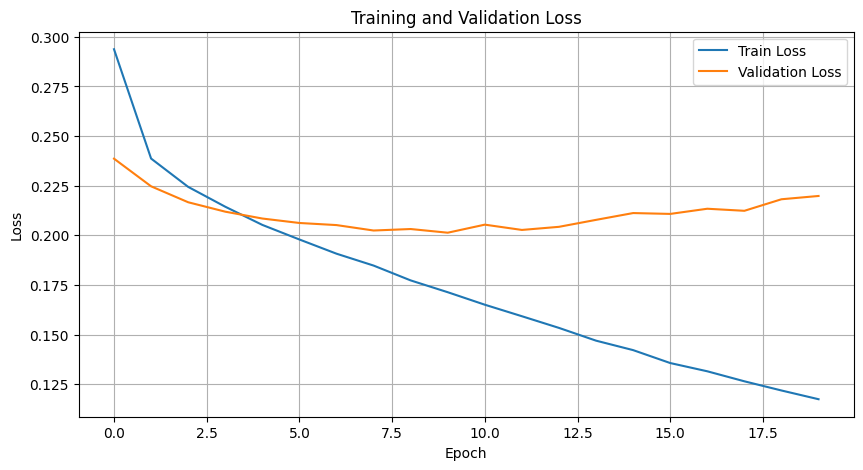

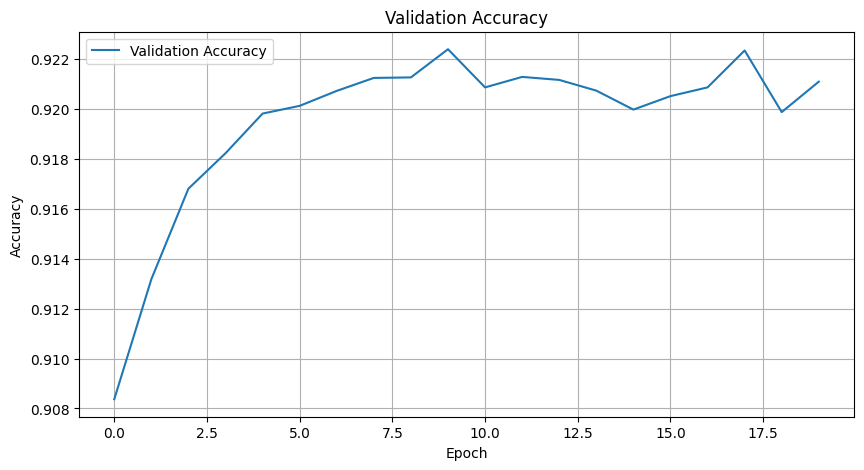

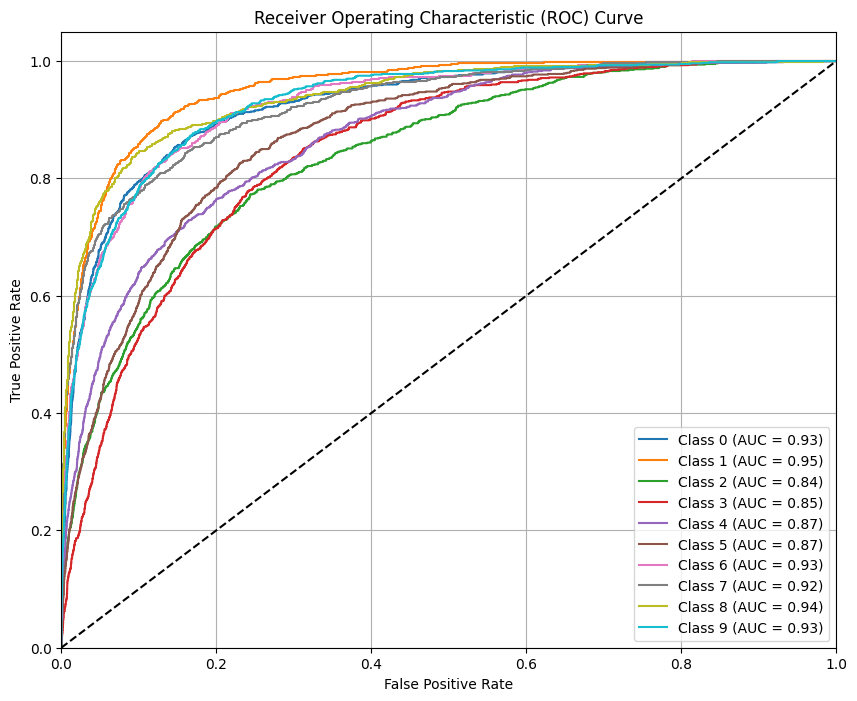

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets  # 导入 datasets
import numpy as np
import os  # 导入 os
import matplotlib.pyplot as plt  # 导入绘图库
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc  # 导入评估指标
import seaborn as sns  # 导入 seaborn，用于美化图表

# 1. 定义 PLE 模型 (保持不变)
class Expert(nn.Module):
    """专家网络模块"""

    def __init__(self, input_dim, hidden_units, activation='relu',
                 dropout=0, use_bn=False, init_std=1e-4):
        super().__init__()
        self.layers = nn.ModuleList()
        input_size = input_dim
        for units in hidden_units:
            self.layers.append(nn.Linear(input_size, units))
            if use_bn:
                self.layers.append(nn.BatchNorm1d(units))
            if activation == 'relu':
                self.layers.append(nn.ReLU())
            elif activation == 'gelu':
                self.layers.append(nn.GELU())
            if dropout > 0:
                self.layers.append(nn.Dropout(dropout))
            input_size = units  # Update input_size for the next layer

        # 参数初始化
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, std=init_std)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class CGCLayer(nn.Module):
    """自定义门控组合层"""

    def __init__(self, input_dim, num_tasks, shared_expert_num, specific_expert_num,
                 expert_hidden_units, gate_hidden_units, activation='relu', dropout=0,
                 use_bn=False, init_std=1e-4):
        super().__init__()
        self.num_tasks = num_tasks
        self.shared_expert_num = shared_expert_num
        self.specific_expert_num = specific_expert_num
        self.expert_hidden_units = expert_hidden_units  # Store expert_hidden_units

        # 任务特定专家
        self.task_experts = nn.ModuleList([
            nn.ModuleList([
                Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
                for _ in range(specific_expert_num)
            ]) for _ in range(num_tasks)
        ])

        # 共享专家
        self.shared_experts = nn.ModuleList([
            Expert(input_dim, expert_hidden_units, activation, dropout, use_bn, init_std)
            for _ in range(shared_expert_num)
        ])

        # 门控网络 - adjust input dim based on expert hidden units
        gate_input_dim = expert_hidden_units[-1] if expert_hidden_units else input_dim  # 输入维度需要与专家网络输出一致
        self.gates = nn.ModuleList([
            nn.Sequential(
                Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),
                nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                          specific_expert_num + shared_expert_num),
                nn.Softmax(dim=-1)
            ) for _ in range(num_tasks)
        ])

        # 共享门控网络 - adjust input dim based on expert hidden units
        self.shared_gate = nn.Sequential(
            Expert(input_dim, gate_hidden_units, activation, dropout, use_bn, init_std),
            nn.Linear(gate_hidden_units[-1] if gate_hidden_units else input_dim,
                      num_tasks * specific_expert_num + shared_expert_num),
            nn.Softmax(dim=-1)
        )

    def forward(self, task_inputs, shared_input):
        # 任务特定专家输出
        task_expert_outputs = []
        for i in range(self.num_tasks):
            task_experts = [expert(task_inputs[i]) for expert in self.task_experts[i]]  # 使用task_inputs[i]而不是shared_input
            task_expert_outputs.extend(task_experts)

        # 共享专家输出
        shared_expert_outputs = [expert(shared_input) for expert in self.shared_experts]

        # 任务门控
        task_outputs = []
        for i in range(self.num_tasks):
            # 组合专家输出
            experts = task_expert_outputs[i * self.specific_expert_num:(i + 1) * self.specific_expert_num]
            experts += shared_expert_outputs
            expert_tensor = torch.stack(experts, dim=1)  # [B, num_experts, dim]

            # 计算门控权重
            gate_weights = self.gates[i](task_inputs[i])  # [B, num_experts]  输入更改为task_inputs[i]

            # 加权融合
            weighted_output = torch.einsum('be,bed->bd', gate_weights, expert_tensor)
            task_outputs.append(weighted_output)

        # 共享门控
        all_experts = task_expert_outputs + shared_expert_outputs
        expert_tensor = torch.stack(all_experts, dim=1)  # [B, total_experts, dim]

        # 计算共享门控权重
        shared_gate_weights = self.shared_gate(shared_input)

        # 共享输出
        shared_output = torch.einsum('be,bed->bd', shared_gate_weights, expert_tensor)

        return task_outputs, shared_output


class PLE(nn.Module):
    """渐进式分层抽取网络"""

    def __init__(self, input_dim, num_tasks, num_levels=2,
                 shared_expert_num=1, specific_expert_num=1,
                 expert_hidden_units=(256,), tower_hidden_units=(64,),
                 gate_hidden_units=(), activation='relu', dropout=0,
                 use_bn=False, task_types=('binary', 'binary'), init_std=1e-4):
        super().__init__()
        self.num_tasks = num_tasks
        self.num_levels = num_levels

        # 构建多层CGC
        self.cgc_layers = nn.ModuleList()
        for level in range(num_levels):
            self.cgc_layers.append(
                CGCLayer(
                    input_dim=input_dim if level == 0 else expert_hidden_units[-1],
                    # 第一层输入是input_dim，后续是expert_hidden_units的输出
                    num_tasks=num_tasks,
                    shared_expert_num=shared_expert_num,
                    specific_expert_num=specific_expert_num,
                    expert_hidden_units=expert_hidden_units,
                    gate_hidden_units=gate_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                )
            )

        # 任务特定塔网络
        self.towers = nn.ModuleList()
        for i in range(num_tasks):
            tower = nn.Sequential(
                Expert(
                    input_dim=expert_hidden_units[-1],  # 输入维度和expert的输出维度一致
                    hidden_units=tower_hidden_units,
                    activation=activation,
                    dropout=dropout,
                    use_bn=use_bn,
                    init_std=init_std
                ),
                nn.Linear(tower_hidden_units[-1] if tower_hidden_units else expert_hidden_units[-1], 1)  # 线性层输入
            )
            self.towers.append(tower)

        # 输出激活函数
        self.task_activations = nn.ModuleList([
            nn.Sigmoid() if task_type == 'binary' else nn.Identity()
            for task_type in task_types
        ])

    def forward(self, x):
        # 初始化输入：每个任务和共享输入相同
        task_inputs = [x.clone() for _ in range(self.num_tasks)]
        shared_input = x.clone()

        # 逐层处理
        for cgc_layer in self.cgc_layers:
            task_inputs, shared_input = cgc_layer(task_inputs, shared_input)
            # 添加残差连接  这里残差连接不应该直接加，而是只针对task_inputs
            for i in range(self.num_tasks):
                task_inputs[i] = task_inputs[i]  # + shared_input

        # 最终预测
        outputs = []
        for i in range(self.num_tasks):
            logit = self.towers[i](task_inputs[i])
            output = self.task_activations[i](logit)
            outputs.append(output)

        return torch.cat(outputs, dim=1)


# 2. CIFAR-10 数据集加载和预处理
def load_cifar10(batch_size, img_size=32):
    # 数据预处理
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),  # 如果需要，可以调整大小
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # 加载训练集
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # 加载测试集
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader


## 3. 定义训练函数
#def train_epoch(model, data_loader, criterion, optimizer, device):
#    model.train()
#    running_loss = 0.0
#    for batch_idx, (images, labels) in enumerate(data_loader):
#        images = images.to(device)
#        # 将标签转换为 one-hot 编码，然后转换为 float32
#        labels_onehot = F.one_hot(labels, num_classes=10).float().to(device)
#        optimizer.zero_grad()
#        outputs = model(images)
#        loss = criterion(outputs, labels_onehot)  #  计算 loss
#        loss.backward()
#        optimizer.step()
#        running_loss += loss.item()
#
#    epoch_loss = running_loss / len(data_loader)
#    return epoch_loss
#
#

# 3. 定义训练函数
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        # 将标签转换为 one-hot 编码，然后转换为 float32
        labels_onehot = F.one_hot(labels, num_classes=10).float().to(device)
        optimizer.zero_grad()

        # Reshape images to match the input dimension of the model
        images = images.view(images.size(0), -1) # Flatten the images correctly

        outputs = model(images)
        loss = criterion(outputs, labels_onehot)  #  计算 loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(data_loader)
    return epoch_loss


def evaluate(model, data_loader, criterion, device, num_classes=10):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    all_outputs = []  # 存储模型的原始输出 (logits)

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels_onehot = F.one_hot(labels, num_classes=num_classes).float().to(device)

            # Reshape images for evaluation
            images = images.view(images.size(0), -1)

            outputs = model(images)
            loss = criterion(outputs, labels_onehot)
            running_loss += loss.item()

            # 将预测结果和标签转换为numpy数组
            predictions = (outputs > 0.5).int()  # 使用 0.5 作为阈值进行二分类
            all_labels.append(labels_onehot.cpu().numpy())  # 使用 one-hot 编码的标签
            all_predictions.append(predictions.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())  # 存储原始输出 (logits)

    epoch_loss = running_loss / len(data_loader)
    all_labels = np.concatenate(all_labels, axis=0)  # (样本数, num_classes)
    all_predictions = np.concatenate(all_predictions, axis=0)  # (样本数, num_classes)
    all_outputs = np.concatenate(all_outputs, axis=0)  # (样本数, num_classes)

    # 计算各种指标，针对多任务二分类
    accuracy = (all_predictions == all_labels).mean()  # 计算整体准确率 (所有任务)
    precision = precision_score(all_labels.ravel(), all_predictions.ravel())
    recall = recall_score(all_labels.ravel(), all_predictions.ravel())
    f1 = f1_score(all_labels.ravel(), all_predictions.ravel())

    # 计算每个类别的指标
    per_class_accuracy = (all_predictions == all_labels).mean(axis=0)  # 每个类别的准确率
    per_class_precision = precision_score(all_labels, all_predictions, average=None)
    per_class_recall = recall_score(all_labels, all_predictions, average=None)
    per_class_f1 = f1_score(all_labels, all_predictions, average=None)

    # 计算 ROC 和 AUC (每个类别)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_outputs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return epoch_loss, accuracy, precision, recall, f1, per_class_accuracy, per_class_precision, per_class_recall, per_class_f1, fpr, tpr, roc_auc


# 4. 主函数
if __name__ == "__main__":
    #  设置超参数
    img_size = 32  # 图像大小
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 20  # 训练轮数
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # CIFAR-10 相关设置
    num_classes = 10  # CIFAR-10 的类别数量
    num_tasks = num_classes  # 每个类别作为一个任务

    # 加载数据集
    train_loader, test_loader = load_cifar10(batch_size, img_size)

    # 初始化模型
    input_dim = 3 * img_size * img_size  #  根据图像大小计算输入维度
    model = PLE(
        input_dim=input_dim,
        num_tasks=num_tasks,
        num_levels=2,
        shared_expert_num=1,
        specific_expert_num=1,
        expert_hidden_units=(256, 128),
        tower_hidden_units=(64,),
        gate_hidden_units=(128,),
        dropout=0.2,
        use_bn=True,
        task_types=['binary'] * num_tasks,  #  每个任务都是二分类
    ).to(device)

    # 定义损失函数和优化器
    criterion = nn.BCELoss()  # 二元交叉熵损失
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 训练循环
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, accuracy, precision, recall, f1, per_class_accuracy, per_class_precision, per_class_recall, per_class_f1, fpr, tpr, roc_auc = evaluate(
            model, test_loader, criterion, device, num_classes
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)  # 存储整体准确率

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        print(f"  Per-Class Accuracy: {per_class_accuracy}")
        print(f"  Per-Class Precision: {per_class_precision}")
        print(f"  Per-Class Recall: {per_class_recall}")

    print("Training finished!")

    # 5. 绘制图表
    # 5.1 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5.2 绘制准确率曲线
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5.3 绘制 ROC 曲线
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()



In [8]:
!pip install torchinfo

In [9]:
from torchinfo import summary
# 打印模型结构
input_size = (batch_size, input_dim)  # 定义一个输入张量的形状
print(summary(model, input_size=input_size, col_names=["input_size", "output_size", "num_params", "mult_adds"]))


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
PLE                                                     [128, 3072]               [128, 10]                 --                        --
├─ModuleList: 1-1                                       --                        --                        --                        --
│    └─CGCLayer: 2-1                                    [128, 3072]               [128, 128]                --                        --
│    │    └─ModuleList: 3-1                             --                        --                        8,203,520                 --
│    │    └─ModuleList: 3-2                             --                        --                        820,352                   --
│    │    └─ModuleList: 3-3                             --                        --                        3,938,580                 --
│    │    └─Sequential: 3-4       

In [10]:
!pip install torchviz

In [11]:
from torchviz import make_dot  # 导入 torchviz
# 绘制模型结构图
# 创建一个 dummy input
dummy_input = torch.randn(batch_size, input_dim).to(device)
#  如果你的模型有多个输入，你需要相应地构造 dummy input
out = model(dummy_input)
dot = make_dot(out, params=dict(model.named_parameters()))
dot.render("ple_model", format="png")  # 保存为 png 图片
print("Model graph saved as ple_model.png")

Model graph saved as ple_model.png
